# TODO

In [ ]:
# TODO:

# frame business and analytical problem

# pre processing:
    # Data Quality Assessment
        # missing value
        # inconsistent value
        # duplicate value
        # outlier
        # imbalanced
    # Feature Aggregation (e.g. monthly to yearly transactions) - NA
    # Feature Sampling - NA
    # Dimensionality Reduction
        # Principal Component Analysis 
        # Singular Value Decomposition
        # Boruta for feature selection
    # Feature Encoding
        # Continuous:
            # Nominal: on-hot-encoding
            # Ordinal
        # Numeric:
            # Interval
            # Ratio
    # *Feature Discretization - improve signal-to-noise ratio


# Model:
# over/under sampling
# sensitive hyper parameters (e.g. max_depth for decision tree, Learning rate and n_estimators for GBDT)
# tree numbers is critical in terms of overfitting
# *L1 regulizer
# *get score probability
# *get shap explaination


# Evaluation:
    # Confusion matrix:
        # TP, TN, FP, FN
        # Accuracy, precision, recall, FPR, F1 score
    # ROC curve
    # precision-recall curve (precision-recall tradeoff)
    # Logarithmic Loss
    # imbalanced:
        # cost-sensitive accuracy
        # per-class accuracy
        # precision, recall
        # Cohen’s kappa statistic

# Import packages

In [49]:
import pandas as pd
import numpy as np
from pycaret.classification import *
from imblearn.under_sampling import RandomUnderSampler
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Preprocessing

In [2]:
dataset = pd.read_csv('data.csv')

## Data Quality Assessment
missing value - NA\
inconsistent value\
duplicate value\
outlier\
imbalanced: Bankrupt? - 1: 3.2%(220), 0: 96.8%(6599)\
zeros: Liability-Assets Flag - 1: 0.01%(8), 0: 99.9%(6811)\
constant values: Net Income Flag (value=1)

In [13]:
# check Liability-Assets Flag
df = dataset[dataset[" Liability-Assets Flag"]==1]
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
56,1,0.066933,0.057185,0.054821,0.601861,0.601861,0.998825,0.796779,0.808717,0.302760,0.780927,2.766025e-04,1.150000e+08,0.458264,3.990399e-04,0.0,0.120012,0.120012,0.120012,0.084239,0.308481,0.045843,0.066200,0.067485,0.022166,0.847569,0.686085,0.686085,0.216971,7.230000e+09,1.542430e-04,0.256152,0.327158,0.004329,0.003309,0.630523,0.126572,0.321371,0.678629,0.004902,0.262035,0.000633,0.066996,0.072453,0.351419,0.292354,0.001311,0.004827,5.042417e-04,6.990039e-04,0.161613,0.048053,0.370209,0.009526,0.692375,0.566755,0.604127,0.210915,4.004091e-03,0.004437,0.252298,0.333539,0.276830,1.196316e-03,0.754574,0.762552,0.241053,0.011706,0.841966,0.002003,0.203706,7.630000e+09,7.650000e+09,0.593893,8.190000e+09,0.671591,0.222815,0.754574,0.241053,0.025851,0.705153,0.464287,0.491813,0.240450,0.065286,1,0.525651,5.803037e-03,0.623648,0.601857,1.000000,0.182790,0.026763,0.565021,1,0.009178
1869,1,0.392775,0.432239,0.432946,0.586921,0.586921,0.998776,0.797126,0.809068,0.303470,0.781325,8.640000e+09,6.600000e+09,0.461523,2.160216e-04,0.0,0.120180,0.120180,0.120180,0.115061,0.319021,0.093244,0.014820,0.084884,0.020457,0.848062,0.689515,0.689515,0.217608,4.220000e+09,1.649235e-04,0.264689,0.422684,0.005246,0.002870,0.630306,0.378620,0.305378,0.694622,0.004129,0.000000,0.005366,0.014787,0.083787,0.000000,0.157421,0.000528,0.01

In [3]:
# drop constant feature
dataset = dataset.drop(columns=[" Net Income Flag"])

## Data partition

In [17]:
data, data_unseen = train_test_split(dataset, test_size=0.1, random_state=42, stratify=dataset["Bankrupt?"])

In [18]:
data_unseen.shape

(682, 95)

In [19]:
data_unseen[data_unseen["Bankrupt?"]==1].shape

(22, 95)

# Modeling

## Compare models

In [20]:
numeric_features = data.columns.values.tolist()
numeric_features.remove("Bankrupt?")
ru = RandomUnderSampler(random_state=123)
clf = setup(data = data, 
            target = 'Bankrupt?',
            numeric_features = numeric_features,
            session_id=888, 
            remove_multicollinearity = True,
            normalize = True,
            pca = True,
            pca_components = 0.99,
            feature_selection = True, 
            feature_selection_threshold = 0.1,
            fix_imbalance=True, 
            fix_imbalance_method=ru,
            data_split_stratify = True,
            fold_shuffle = True)

,Description,Value
0,session_id,888
1,Target,Bankrupt?
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6137, 95)"
5,Missing Values,False
6,Numeric Features,94
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [33]:
best_model=compare_models(sort = 'Prec.')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.9104,0.8692,0.5198,0.1863,0.2734,0.2371,0.2734,0.0100
lda,Linear Discriminant Analysis,0.8640,0.9156,0.8423,0.1768,0.2910,0.2508,0.3466,0.0110
ridge,Ridge Classifier,0.8636,0.0000,0.8423,0.1760,0.2900,0.2498,0.3457,0.0120
lr,Logistic Regression,0.8591,0.9050,0.8346,0.1701,0.2815,0.2406,0.3365,0.0200
svm,SVM - Linear Kernel,0.8461,0.0000,0.7775,0.1567,0.2566,0.2144,0.3018,0.0100
et,Extra Trees Classifier,0.8370,0.9302,0.9000,0.1567,0.2663,0.2235,0.3345,0.1210
knn,K Neighbors Classifier,0.8366,0.9128,0.9066,0.1563,0.2663,0.2234,0.3359,0.0230
lightgbm,Light Gradient Boosting Machine,0.8384,0.9201,0.8714,0.1556,0.2631,0.2203,0.3259,0.0250
gbc,Gradient Boosting Classifier,0.8363,0.9215,0.8714,0.1539,0.2605,0.2175,0.3235,0.0990
rf,Random Forest Classifier,0.8380,0.9245,0.8643,0.1528,0.2590,0.2159,0.3211,0.1600


In [34]:
qda = create_model('qda', return_train_score = True)

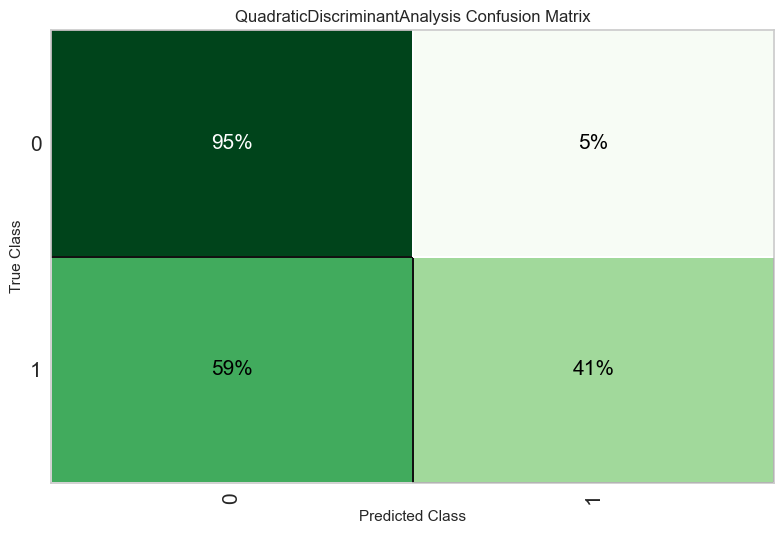

In [35]:
plot_model(qda, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

## Fine turning model

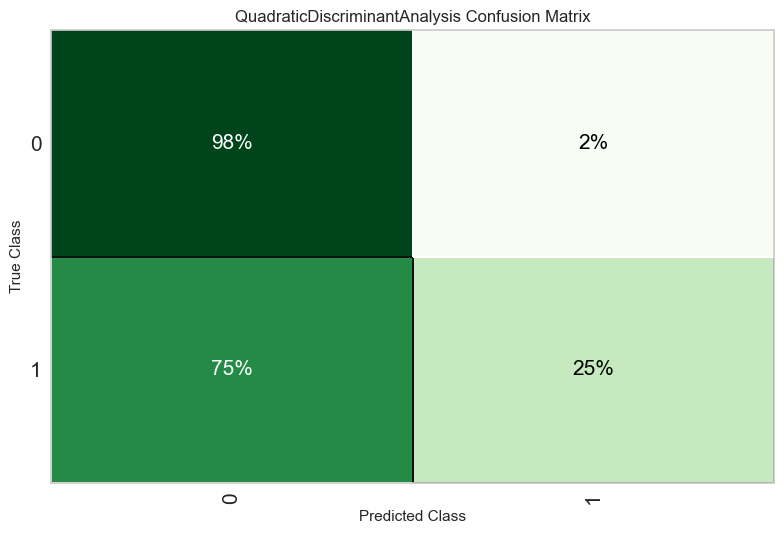

In [36]:
tuned_qda = tune_model(qda, optimize = 'Prec.')
plot_model(tuned_qda, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

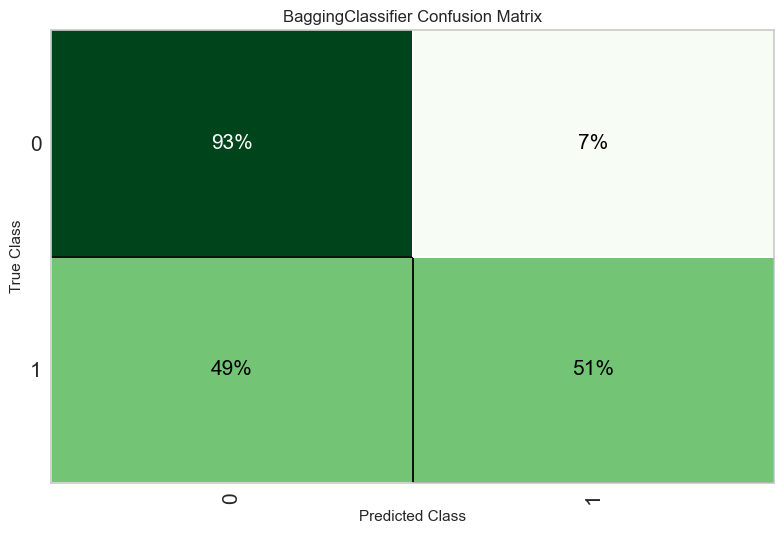

In [37]:
boosted_qda = ensemble_model(qda, optimize = 'Prec.')
plot_model(boosted_qda, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

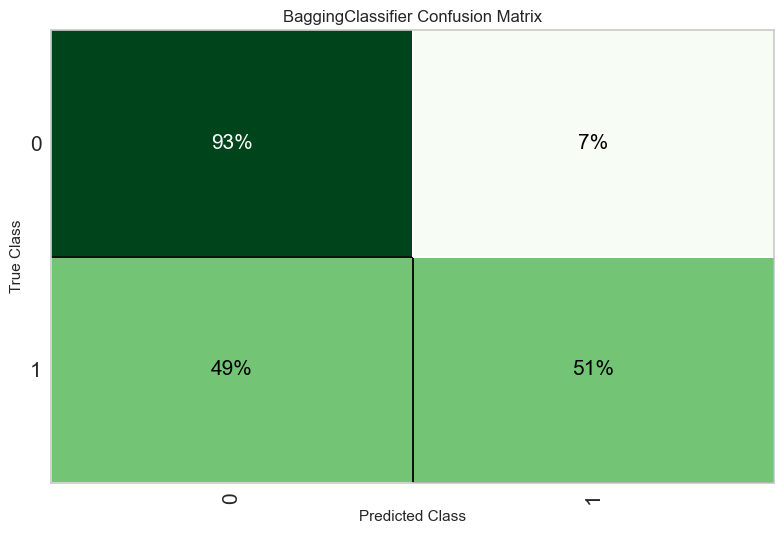

In [38]:
bagged_qda = ensemble_model(qda, method = 'Bagging')
plot_model(bagged_qda, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

## Plot model

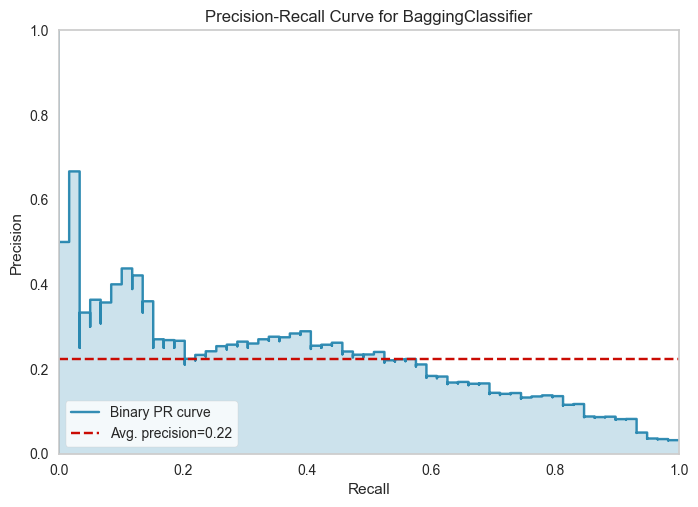

In [39]:
plot_model(boosted_qda, plot = 'pr')

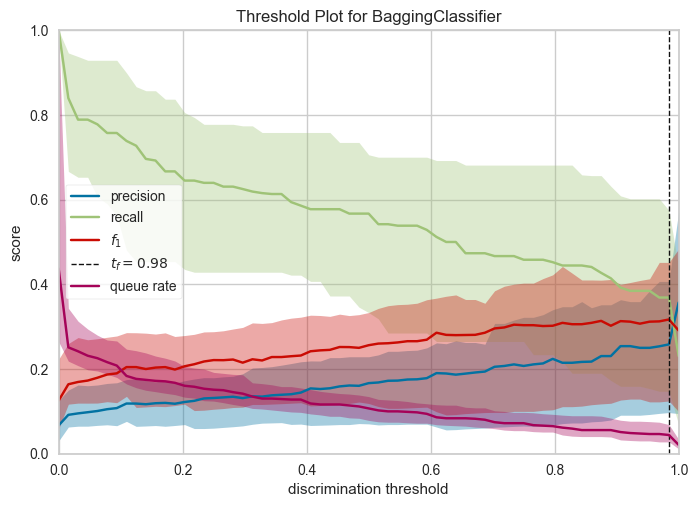

In [40]:
plot_model(boosted_qda, plot = 'threshold')

# Evaluation

## evaluate unseen data

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.9062,0.8937,0.6364,0.2000,0.3043,0.2684,0.3211


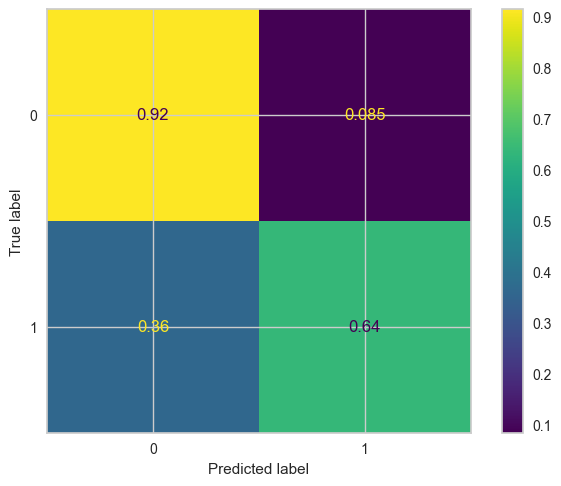

In [132]:
unseen_predictions = predict_model(boosted_qda, data=data_unseen)
cm = confusion_matrix(unseen_predictions["Bankrupt?"], unseen_predictions["Label"], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## hotfix

<AxesSubplot: xlabel='Label', ylabel='Score'>

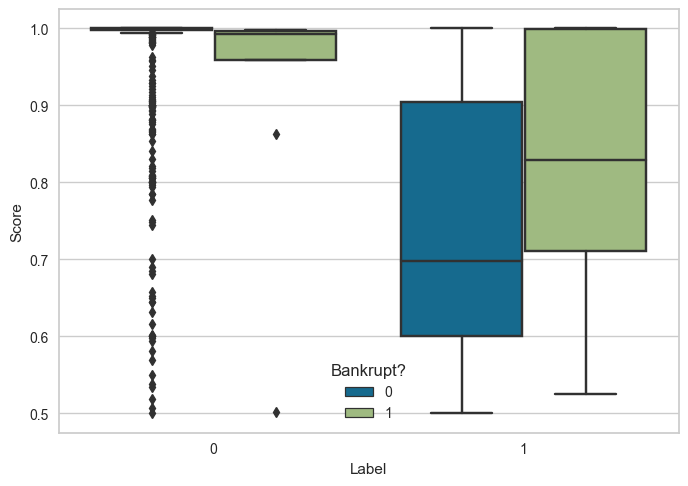

In [133]:
sns.boxplot(x = unseen_predictions["Label"],
            y = unseen_predictions["Score"],
           hue = unseen_predictions["Bankrupt?"])

In [134]:
unseen_predictions.loc[(unseen_predictions["Label"] == 0) & (unseen_predictions["Score"] < 0.9), "Filtered_label"] = 1
unseen_predictions.Filtered_label.fillna(unseen_predictions.Label, inplace=True)

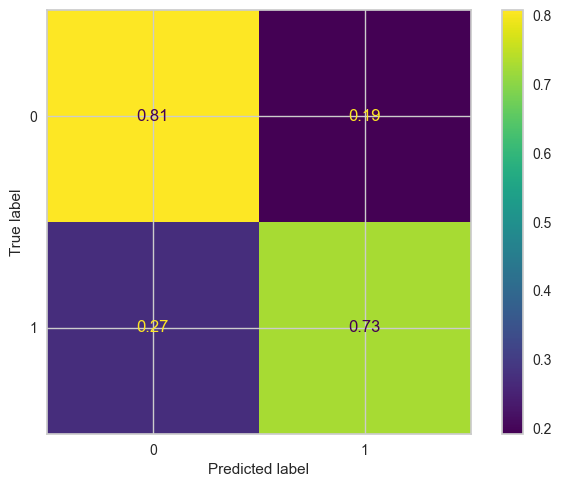

In [135]:
cm = confusion_matrix(unseen_predictions["Bankrupt?"], unseen_predictions["Filtered_label"], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## save model

In [137]:
save_model(boosted_qda,'saved_models/qda')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[' ROA(C) before '
                                                           'interest and '
                                                           'depreciation before '
                                                           'interest',
                                                           ' ROA(A) before '
                                                           'interest and % '
                                                           'after tax',
                                                           ' ROA(B) before '
                                                           'interest and '
 